# Importations

In [169]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from glob import glob

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# for dirname, _, filenames in os.walk("/kaggle/input"):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# ToDoList

- Preprocess CSV file
- Preprocess images
- Build CNN model for images trained on labels
- Make the CNN model return a probability vector
- Use a MLP model to add table features with this probabilty vector
- Tune both models

# Infos

- I will start with simple model and preprocessing, not trying to create visual border around the disease
- I won"t use some of the table features at the beginning

# Global variables

In [170]:
DATA_ENTRY_CSV_PATH = "../input/data/Data_Entry_2017.csv"
IMG_SIZE = (128, 128)
VALID_SET_PERCENT = 0.2
#LABELS
#N_LABELS
#ONE_HOT_LABELS

# Preprocess CSV file

In [171]:
data_entry_df = pd.read_csv(DATA_ENTRY_CSV_PATH)
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join("..", "input", "data", "images*", "*", "*.png"))}
print("Images found:", len(all_image_paths), ", Total headers", data_entry_df.shape[0])
data_entry_df["path"] = data_entry_df["Image Index"].map(all_image_paths.get)
#data_entry_df["Patient Age"] = data_entry_df["Patient Age"].map(lambda x: int(x[:-1]))
data_entry_df.sample(3)

Images found: 112120 , Total headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
78126,00019176_036.png,Atelectasis|Consolidation|Effusion,36,19176,68,F,AP,3056,2544,0.139,0.139,NaN,../input/data/images_009/images/00019176_036.png
73680,00018117_013.png,Pneumothorax,13,18117,34,M,PA,2822,2673,0.143,0.143,NaN,../input/data/images_008/images/00018117_013.png
41456,00010718_010.png,No Finding,10,10718,41,M,AP,2500,2048,0.168,0.168,NaN,../input/data/images_005/images/00010718_010.png


## --> Get labels and create binary rows

In [172]:
data_entry_df["Finding Labels"] = data_entry_df["Finding Labels"].map(lambda x: x.replace("No Finding", ""))
from itertools import chain
all_labels = np.unique(list(chain(*data_entry_df["Finding Labels"].map(lambda x: x.split("|")).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print("All Labels ({}): {}".format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data_entry_df[c_label] = data_entry_df["Finding Labels"].map(lambda finding: 1.0 if c_label in finding else 0)
data_entry_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
107656,00029088_022.png,,22,29088,47,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111375,00030439_001.png,Infiltration,1,30439,56,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43811,00011291_001.png,Mass,1,11291,30,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## --> Plot labels

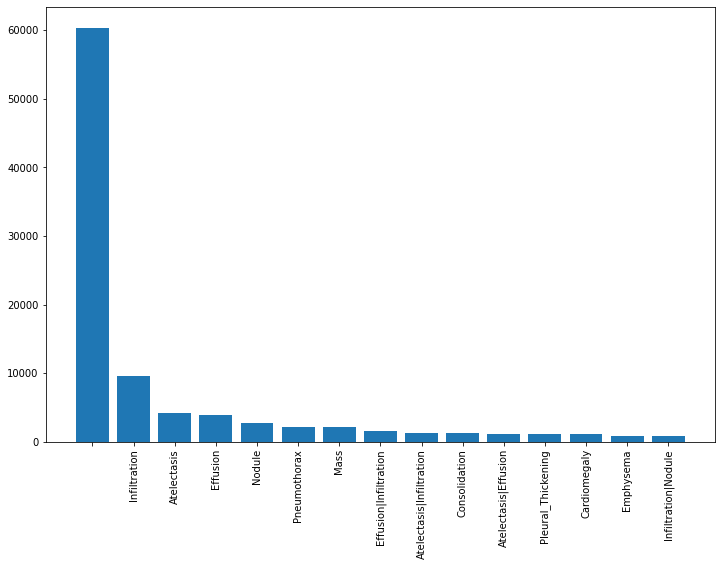

In [173]:
label_counts = data_entry_df["Finding Labels"].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

## --> Keep only useful labels

In [174]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data_entry_df[c_label].sum()>MIN_CASES]
print("Clean Labels ({})".format(len(all_labels)), 
      [(c_label,int(data_entry_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


## --> Resample

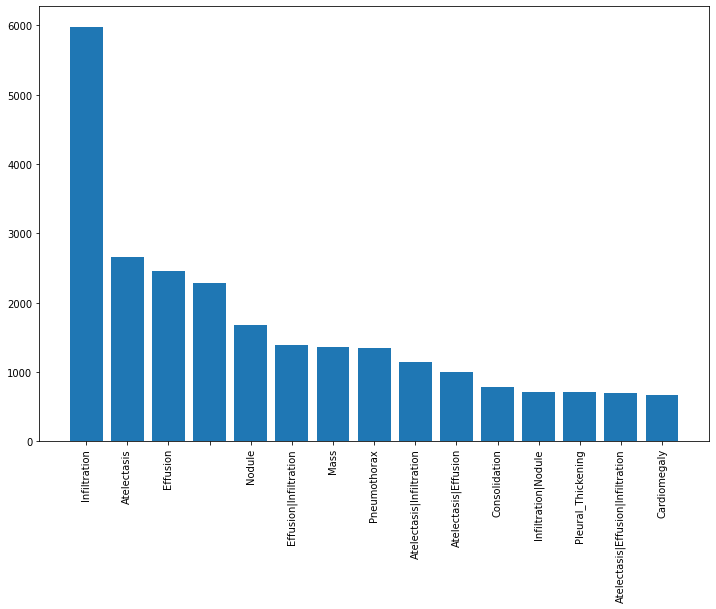

In [175]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = data_entry_df["Finding Labels"].map(lambda x: len(x.split("|")) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data_entry_df = data_entry_df.sample(40000, weights=sample_weights)

label_counts = data_entry_df["Finding Labels"].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

## --> Check labels frequency

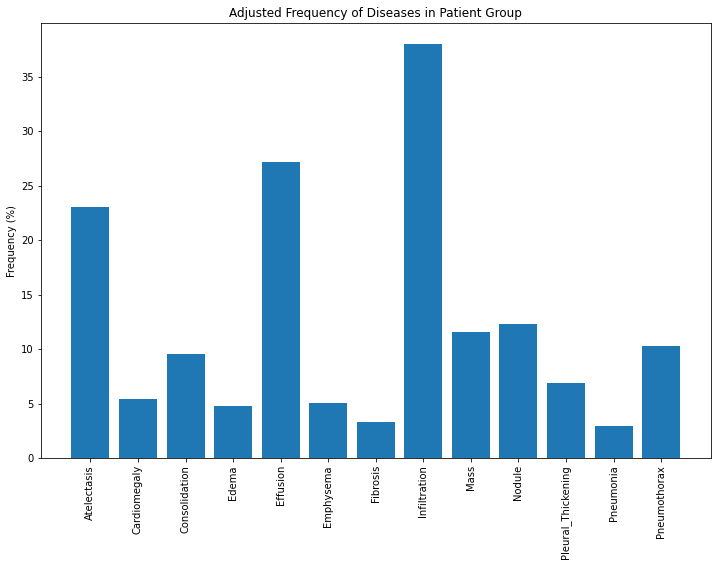

In [176]:
label_counts = 100*np.mean(data_entry_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title("Adjusted Frequency of Diseases in Patient Group")
_ = ax1.set_ylabel("Frequency (%)")

# Preprocess images for the CNN model 

## --> Create disease row

In [177]:
data_entry_df["disease_vec"] = data_entry_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

## --> Splitting training and validation dataset

In [178]:
train_df, valid_df = train_test_split(data_entry_df, 
                                      test_size = VALID_SET_PERCENT, 
                                      stratify = data_entry_df["Finding Labels"].map(lambda x: x[:4]))
print("train size :", train_df.shape[0], ", validation size :", valid_df.shape[0])

train size : 32000 , validation size : 8000


## --> Data Augmentation 

In [179]:
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = "reflect",
                              zoom_range=0.15)

In [180]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                              class_mode = "sparse",
                                              **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ""
    print("Reinserting dataframe: {} images".format(in_df.shape[0]))
    return df_gen

In [181]:
valid_df["newLabel"] = valid_df.apply(lambda x: x["Finding Labels"].split("|"), axis=1)
train_df["newLabel"] = train_df.apply(lambda x: x["Finding Labels"].split("|"), axis=1)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                        directory=None,
                                        x_col = "path",
                                        y_col = "newLabel",
                                        class_mode = "categorical",
                                        classes = all_labels,
                                        target_size = IMG_SIZE,
                                        color_mode = "grayscale",
                                        batch_size = 32)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                        directory=None,
                                        x_col = "path",
                                        y_col = "newLabel",
                                        class_mode = "categorical",
                                        classes = all_labels,
                                        target_size = IMG_SIZE,
                                        color_mode = "grayscale",
                                        batch_size = 256)

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                    directory=None,
                    x_col = "path",
                    y_col = "newLabel",
                    class_mode = "categorical",
                    classes = all_labels,
                    target_size = IMG_SIZE,
                    color_mode = "grayscale",
                    batch_size = 1024))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Found 30104 validated image filenames belonging to 13 classes.
Found 7531 validated image filenames belonging to 13 classes.
Found 7531 validated image filenames belonging to 13 classes.


## --> Showing images with labels

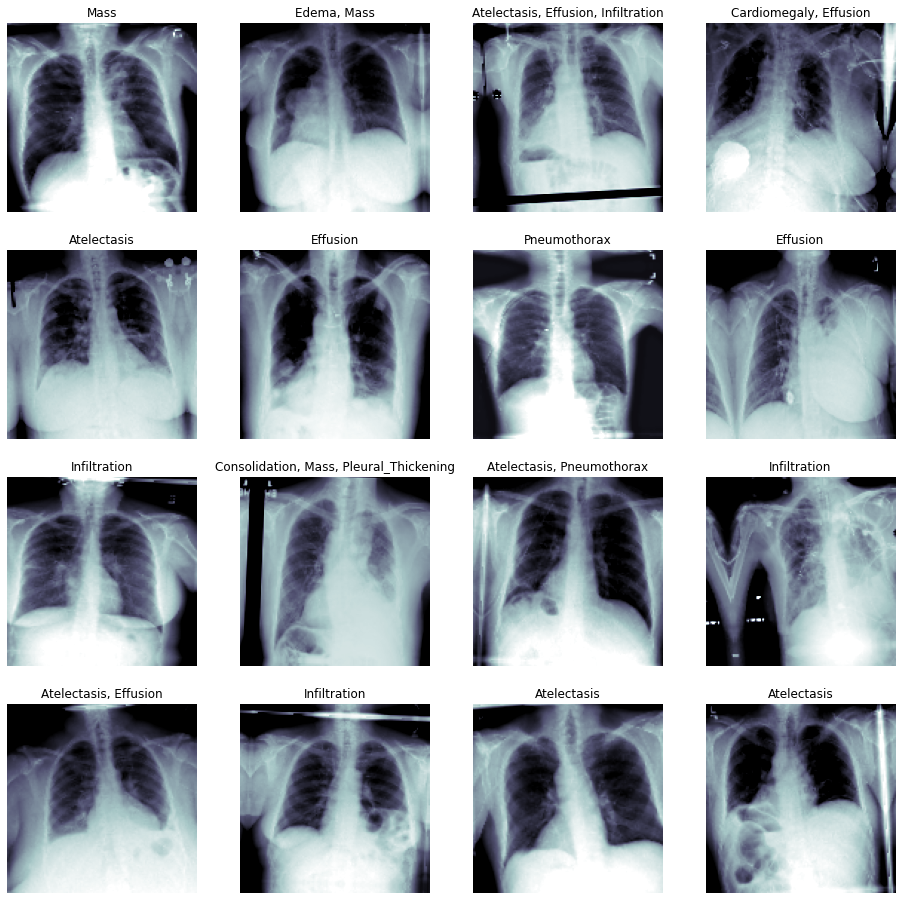

In [182]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = "bone", vmin = -1.5, vmax = 1.5)
    c_ax.set_title(", ".join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis("off")